Import the necessary Python libraries:

In [516]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import silhouette_score

%matplotlib inline

Read the dataset into a pandas DataFrame:

In [517]:
df = pd.read_excel('Data Scientist Assignment - Senior Analyst v1.0.xlsx', sheet_name='Customer Data', skiprows=1)

The number of rows and columns in the DataFrame:

In [518]:
df.shape

(84080, 14)

# Data Preprocessing

The column names in the dataset are too long. Replace them with more compact column names. The following mapping is used:

In [519]:
df.columns = ['ID', 'Title', 'SpecCode', 'SpecDesc', 'State', 'CallAttempts', 'CallsSuccessful', 'EmailsSent', 'EmailsOpened', 
             'Faxes', 'Brand_1', 'Brand_2', 'TotalBranded', 'TotalMarket']

Take a peek at the dataset:

In [520]:
df.head()

,ID,Title,SpecCode,SpecDesc,State,CallAttempts,CallsSuccessful,EmailsSent,EmailsOpened,Faxes,Brand_1,Brand_2,TotalBranded,TotalMarket
0,10000,MD,FM,FAMILY MEDICINE,SC,0,0,17,0,0,0,NaN,3.0,131
1,10001,MD,CD,CARDIOVASCULAR DISEASES,SC,0,0,17,0,0,0,NaN,NaN,56
2,10002,MD,IM,INTERNAL MEDICINE,AL,0,0,17,0,0,0,NaN,NaN,161
3,10003,MD,FM,FAMILY MEDICINE,AL,6,0,17,0,0,0,NaN,NaN,180
4,10004,MD,CD,CARDIOVASCULAR DISEASES,AL,2,0,17,0,0,0,NaN,4.0,44


'ID' column does not have any effect on our clustering. 'SpecDesc' column is simply a description of the 'SpecCode' column. So we can drop 'ID' and 'SpecDesc' columns from the DataFrame:

In [521]:
df.drop(['ID', 'SpecDesc'], axis = 1, inplace=True)

Take a peek at the dataset:

In [522]:
df.head()

,Title,SpecCode,State,CallAttempts,CallsSuccessful,EmailsSent,EmailsOpened,Faxes,Brand_1,Brand_2,TotalBranded,TotalMarket
0,MD,FM,SC,0,0,17,0,0,0,NaN,3.0,131
1,MD,CD,SC,0,0,17,0,0,0,NaN,NaN,56
2,MD,IM,AL,0,0,17,0,0,0,NaN,NaN,161
3,MD,FM,AL,6,0,17,0,0,0,NaN,NaN,180
4,MD,CD,AL,2,0,17,0,0,0,NaN,4.0,44


Find how many rows in each column are missing values:

In [523]:
df.isna().sum()

Title               6401
SpecCode             757
State                757
CallAttempts           0
CallsSuccessful        0
EmailsSent             0
EmailsOpened           0
Faxes                  0
Brand_1                0
Brand_2            48091
TotalBranded       42385
TotalMarket            0
dtype: int64

Populate the missing values with data as follows:

In [524]:
df['Title'] = df['Title'].fillna('UNK')
df['SpecCode'] = df['SpecCode'].fillna('UNK')
df['State'] = df['State'].fillna('UN')
df['Brand_2'] = df['Brand_2'].fillna(0)
df['TotalBranded'] =  df['TotalBranded'].fillna(df['Brand_1'] + df['Brand_2'])

Take a peek at the dataset:

In [525]:
df.head()

,Title,SpecCode,State,CallAttempts,CallsSuccessful,EmailsSent,EmailsOpened,Faxes,Brand_1,Brand_2,TotalBranded,TotalMarket
0,MD,FM,SC,0,0,17,0,0,0,0.0,3.0,131
1,MD,CD,SC,0,0,17,0,0,0,0.0,0.0,56
2,MD,IM,AL,0,0,17,0,0,0,0.0,0.0,161
3,MD,FM,AL,6,0,17,0,0,0,0.0,0.0,180
4,MD,CD,AL,2,0,17,0,0,0,0.0,4.0,44


Verify there is no missing value.

In [526]:
df.isna().sum()

Title              0
SpecCode           0
State              0
CallAttempts       0
CallsSuccessful    0
EmailsSent         0
EmailsOpened       0
Faxes              0
Brand_1            0
Brand_2            0
TotalBranded       0
TotalMarket        0
dtype: int64

There might be rows in which the value of the 'CallAttempts' column is less than the value of 'CallsSuccessful' column. This is illogical. How many such rows exist:

In [527]:
arrCalls = np.where(df['CallAttempts'] < df['CallsSuccessful'])[0]

print('Number of rows where "CallAttempt" value is less than "CallsSuccessful" value:', len(arrCalls))

Number of rows where "CallAttempt" value is less than "CallsSuccessful" value: 0


There might be rows in which the value of the 'EmailsSent' column is less than the value of 'EmailsOpened' column. This is illogical. How many such rows exist:

In [528]:
arrEmails = np.where(df['EmailsSent'] < df['EmailsOpened'])[0]

print('Number of rows where "EmailsSent" value is less than "EmailsOpened" value:', len(arrEmails))

Number of rows where "EmailsSent" value is less than "EmailsOpened" value: 199


Replace the value of 'EmailsSent' column with the value of 'EmailsOpened' column:

In [529]:
for i in range(0, len(arrEmails)):
        df['EmailsSent'][arrEmails[i]] = df['EmailsOpened'][arrEmails[i]]

There might be rows in which the value of the 'TotalBranded' column is less than the sum of the values of 'Brand_1' and 'Brand_2'. This is illogical because the total sales of all branded items cannot be less than the sum of the sales of brand 1 and brand 2 alone. How many such rows exist:

In [530]:
diffTotalBrands = df['TotalBranded'] - (df['Brand_1'] + df['Brand_2'])

arrTotalBrands = np.where(diffTotalBrands < 0)[0]

print('Number of rows where "TotalBranded" value is less than the sum of "Brand_1" and "Brand_2" values:', len(arrTotalBrands))

Number of rows where "TotalBranded" value is less than the sum of "Brand_1" and "Brand_2" values: 1


Replace the 'TotalBranded' value in such rows with the sum of 'Brand_1' and 'Brand_2':

In [531]:
for i in range(0, len(arrTotalBrands)):
        df['TotalBranded'][arrTotalBrands[i]] = df['Brand_1'][arrTotalBrands[i]] + df['Brand_2'][arrTotalBrands[i]]

There might be rows in which the value of the 'TotalMarket' column is less than the value of the 'TotalBranded' column. This is illogical because the total sales of all branded and unbranded items cannot be less than the sales of the branded items. How many such rows exist:

In [532]:
diffTotalBrandMarket = df['TotalMarket'] - df['TotalBranded']

arrBrandMarket = np.where(diffTotalBrandMarket < 0)[0]

print('Number of rows where "TotalMarket" value is less than the value of "TotalBranded" column:', len(arrBrandMarket))

Number of rows where "TotalMarket" value is less than the value of "TotalBranded" column: 618


Replace the 'TotalMarket' value in such rows with the value of 'TotalBranded':

In [533]:
for i in range(0, len(arrBrandMarket)):
        df['TotalMarket'][arrBrandMarket[i]] = df['TotalBranded'][arrBrandMarket[i]]

Create a column 'OtherBrands' that says what is the total sales of brands other than Brand 1 & Brand 2:

In [534]:
df['OtherBrands'] = df['TotalBranded'] -(df['Brand_1'] + df['Brand_2'])

Create a column 'Unbranded' that says what is the toal sales of unbranded items:

In [535]:
df['Unbranded'] = df['TotalMarket'] -df['TotalBranded']

Take a peek at the dataset:

In [536]:
df.head()

,Title,SpecCode,State,CallAttempts,CallsSuccessful,EmailsSent,EmailsOpened,Faxes,Brand_1,Brand_2,TotalBranded,TotalMarket,OtherBrands,Unbranded
0,MD,FM,SC,0,0,17,0,0,0,0.0,3.0,131,3.0,128.0
1,MD,CD,SC,0,0,17,0,0,0,0.0,0.0,56,0.0,56.0
2,MD,IM,AL,0,0,17,0,0,0,0.0,0.0,161,0.0,161.0
3,MD,FM,AL,6,0,17,0,0,0,0.0,0.0,180,0.0,180.0
4,MD,CD,AL,2,0,17,0,0,0,0.0,4.0,44,4.0,40.0


# Exploratory Data Analysis

Sales data of Brand 1, Brand 2, other brands and unbranded across various titles:

Text(0,0.5,'Sales')

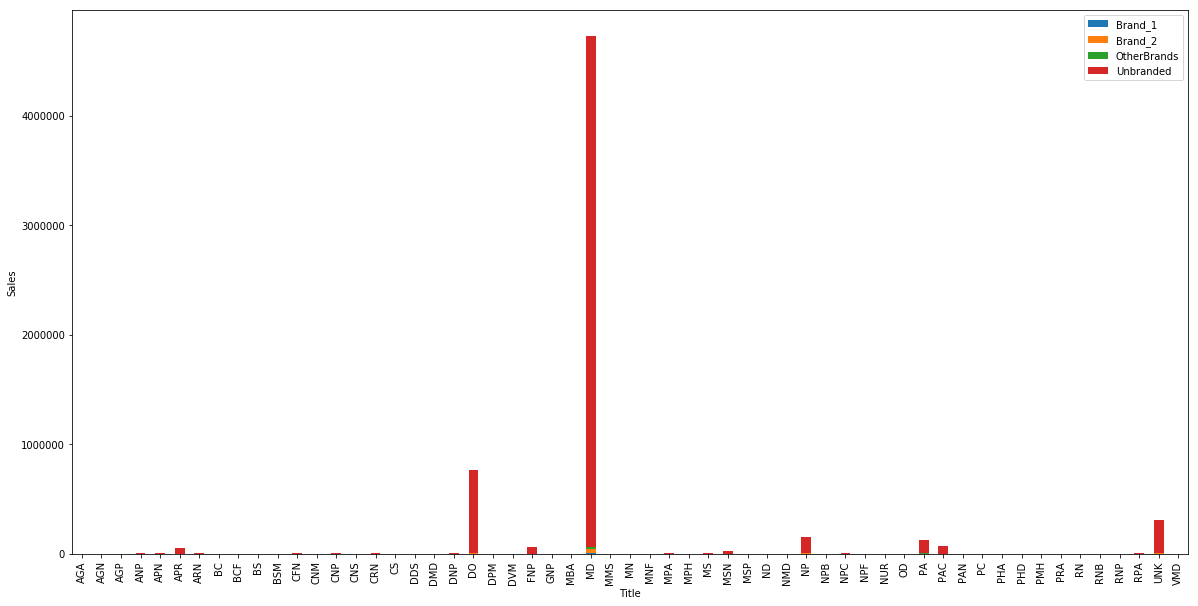

In [537]:
dfTitle = df.groupby('Title').agg('sum')[['Brand_1', 'Brand_2', 'OtherBrands', 'Unbranded']]
ax = dfTitle.plot(kind='bar', figsize=(20,10), stacked=True)
ax.set_ylabel('Sales')

In the plot above, the share of Brand_1, Brand_2, and Other brands is not clearly visible. So let us limit the y axis to (0, 100000) to get a better view:

Text(0,0.5,'Sales')

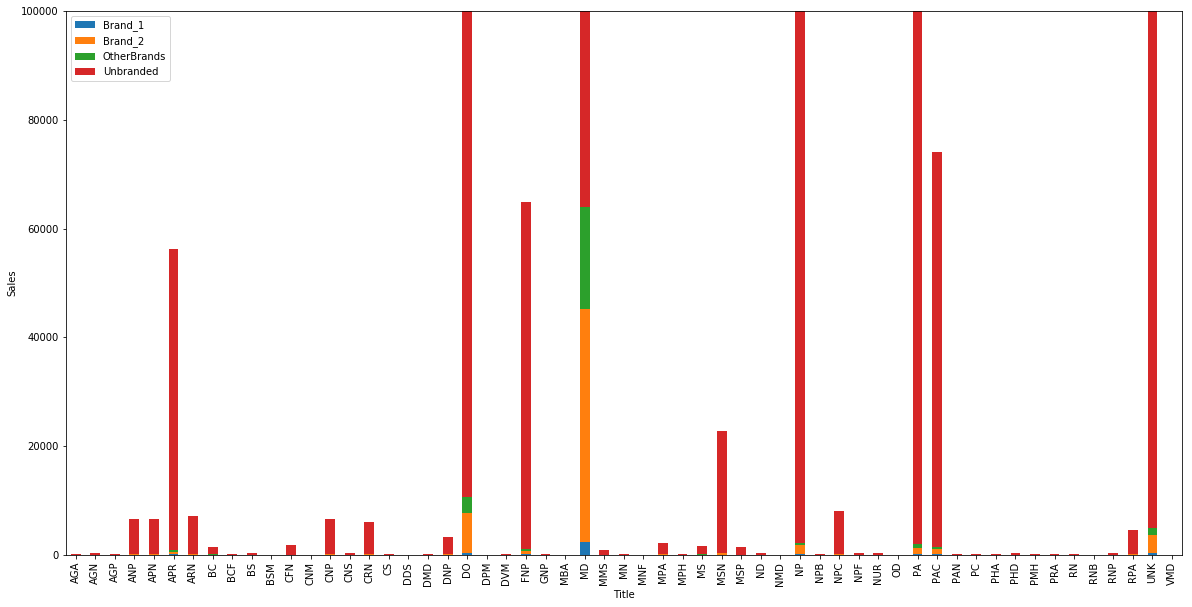

In [538]:
dfTitle = df.groupby('Title').agg('sum')[['Brand_1', 'Brand_2', 'OtherBrands', 'Unbranded']]
ax = dfTitle.plot(kind='bar', figsize=(20,10), stacked=True)
ax.set_ylim(0, 100000)
ax.set_ylabel('Sales')

Sales data of Brand 1, Brand 2, other brands and unbranded across various specialties:

Text(0,0.5,'Sales')

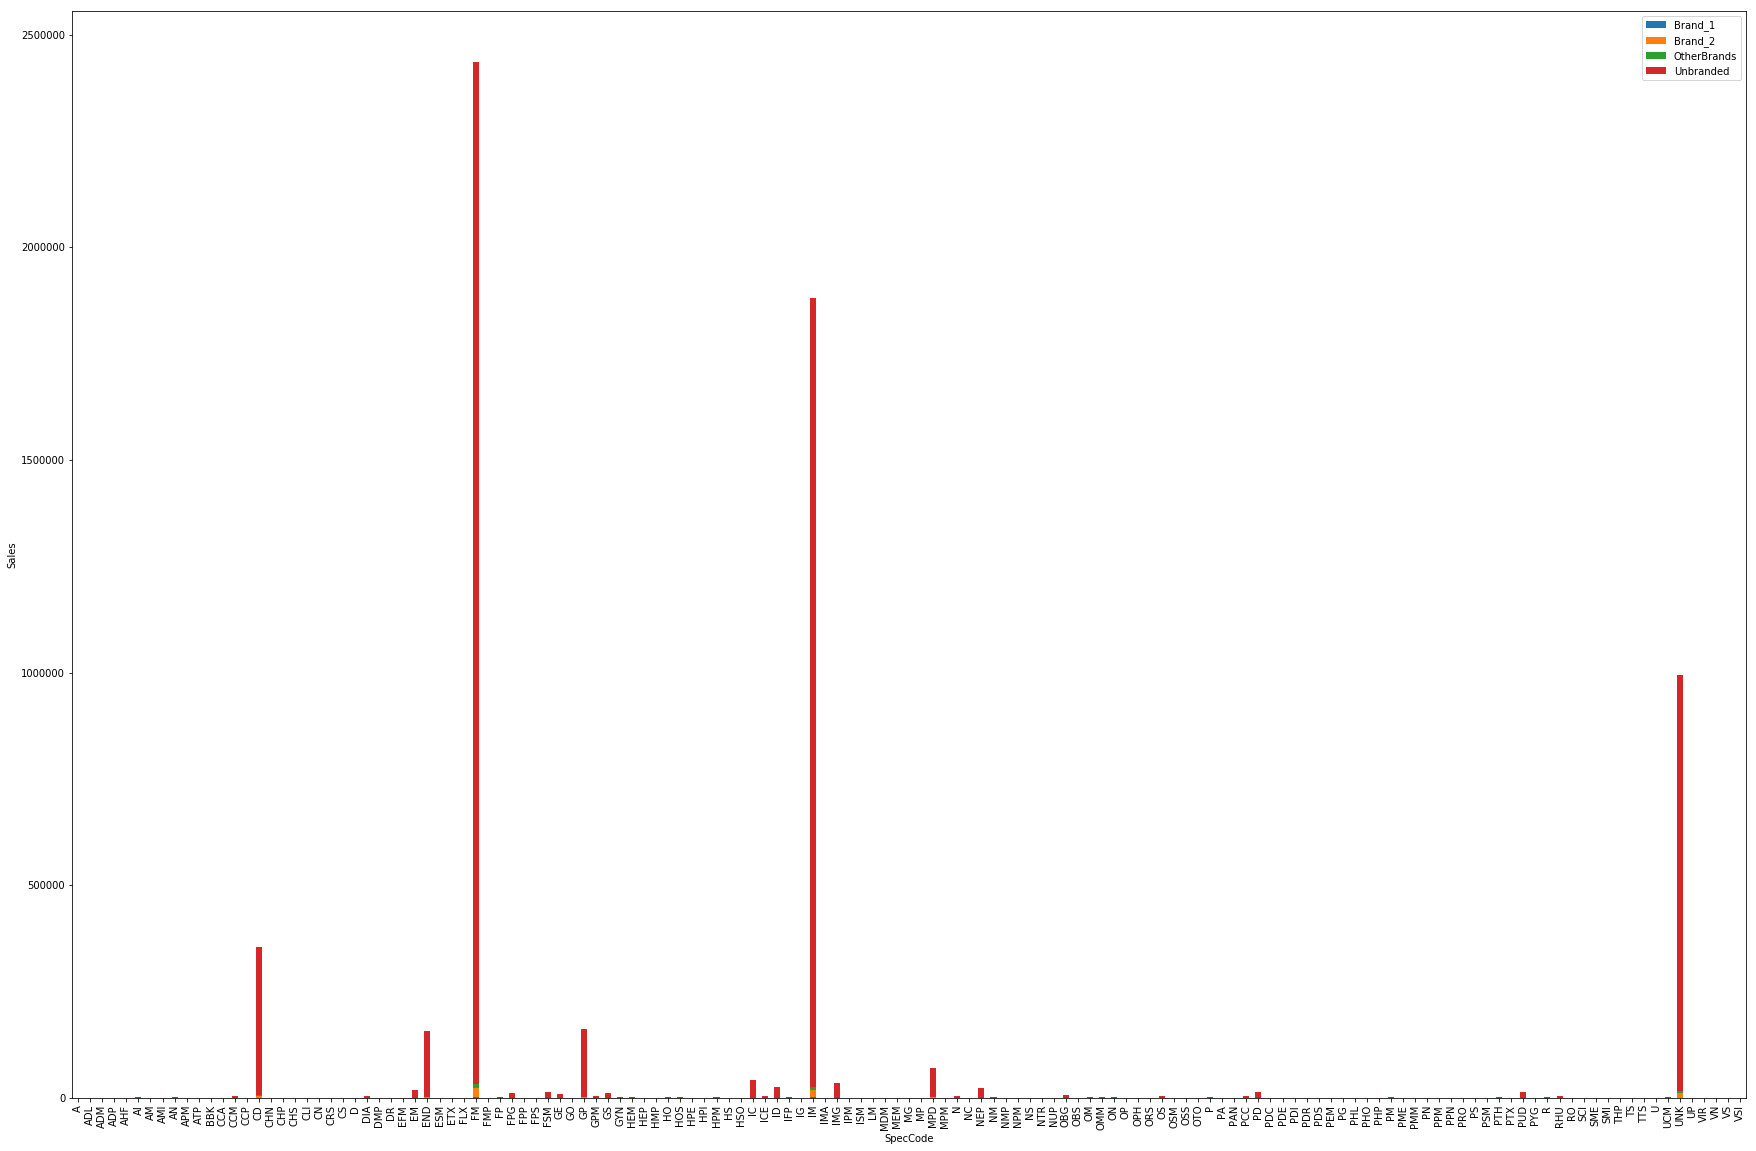

In [539]:
dfSpecCode = df.groupby(['SpecCode']).agg('sum')[['Brand_1', 'Brand_2', 'OtherBrands', 'Unbranded']]
ax = dfSpecCode.plot(kind='bar', figsize=(30,20), stacked=True)
ax.set_ylabel('Sales')

In the plot above, the share of Brand_1, Brand_2, and Other brands is not clearly visible. So let us limit the y axis to (0, 50000) to get a better view:

Text(0,0.5,'Sales')

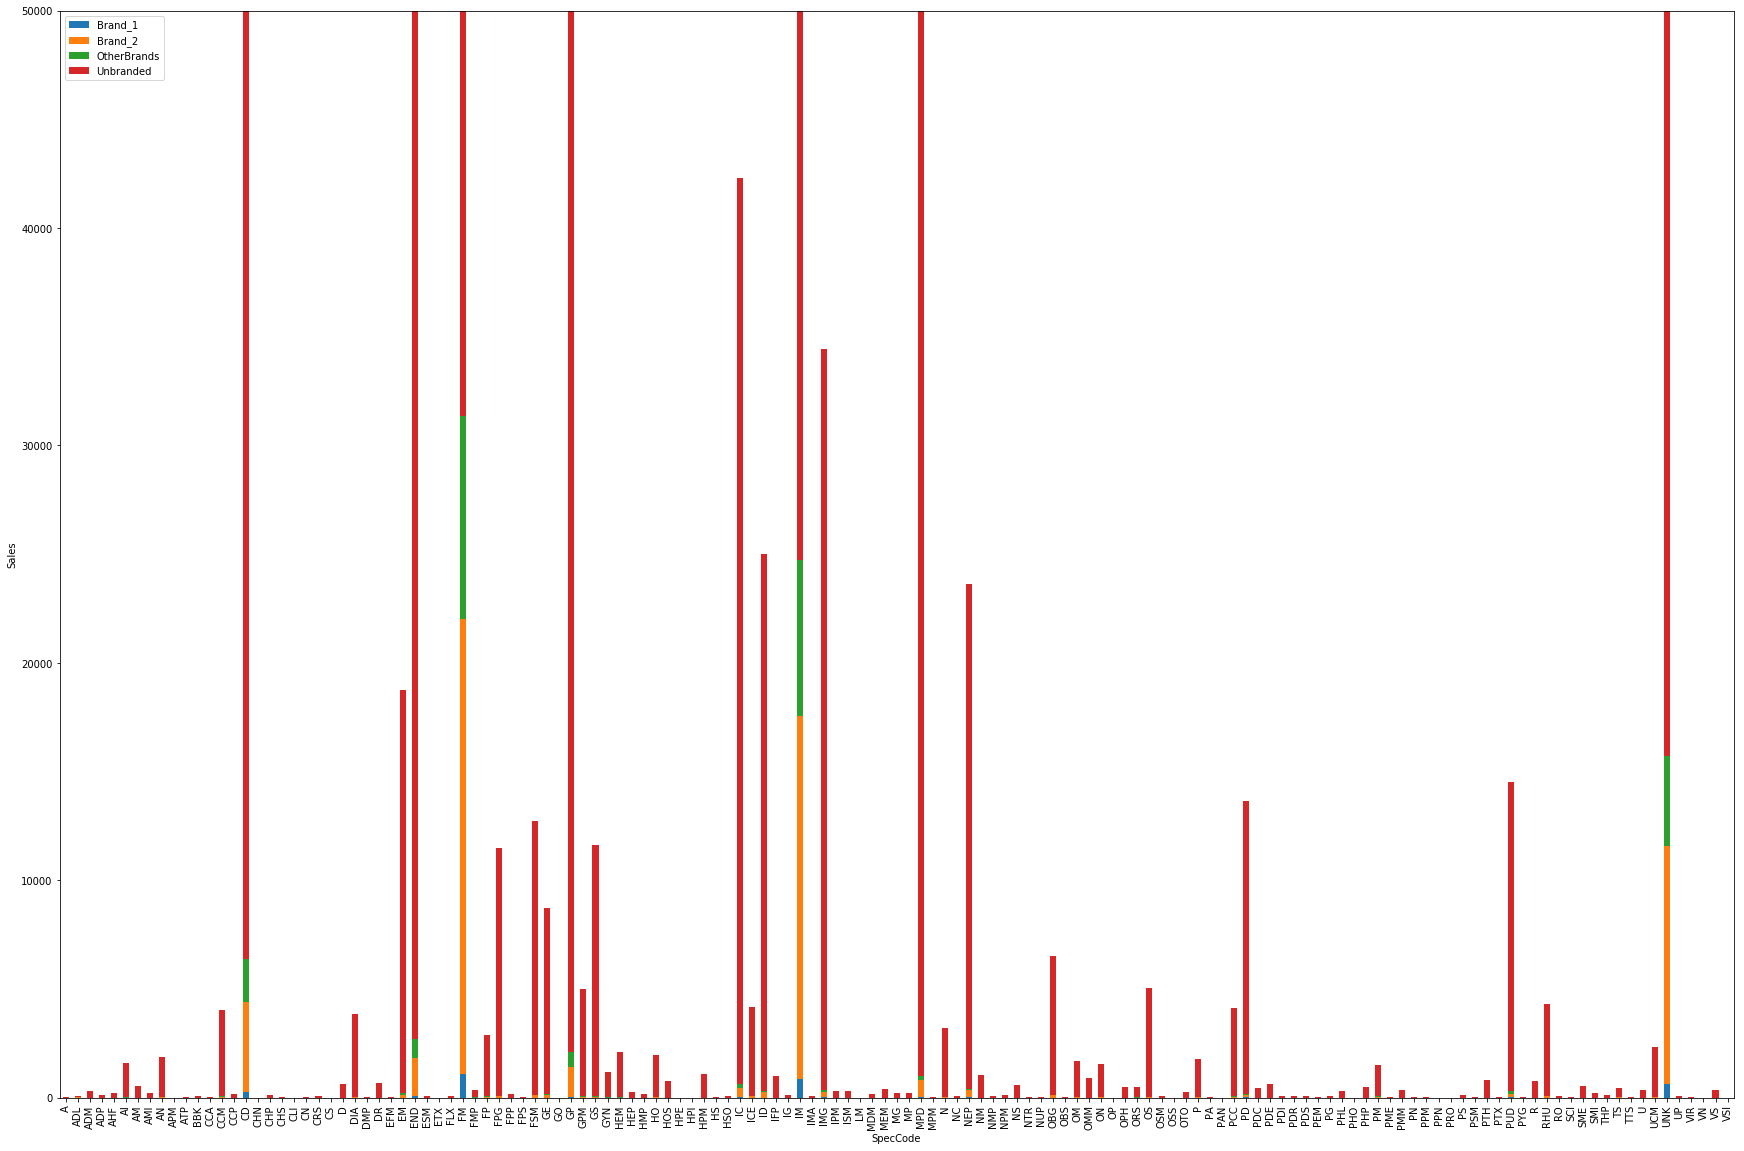

In [540]:
dfSpecCode = df.groupby('SpecCode').agg('sum')[['Brand_1', 'Brand_2', 'OtherBrands', 'Unbranded']]
ax = dfSpecCode.plot(kind='bar', figsize=(30,20), stacked=True)
ax.set_ylim(0, 50000)
ax.set_ylabel('Sales')

Sales data of Brand 1, Brand 2, Other brands and Unbranded across various states:

Text(0,0.5,'Sales')

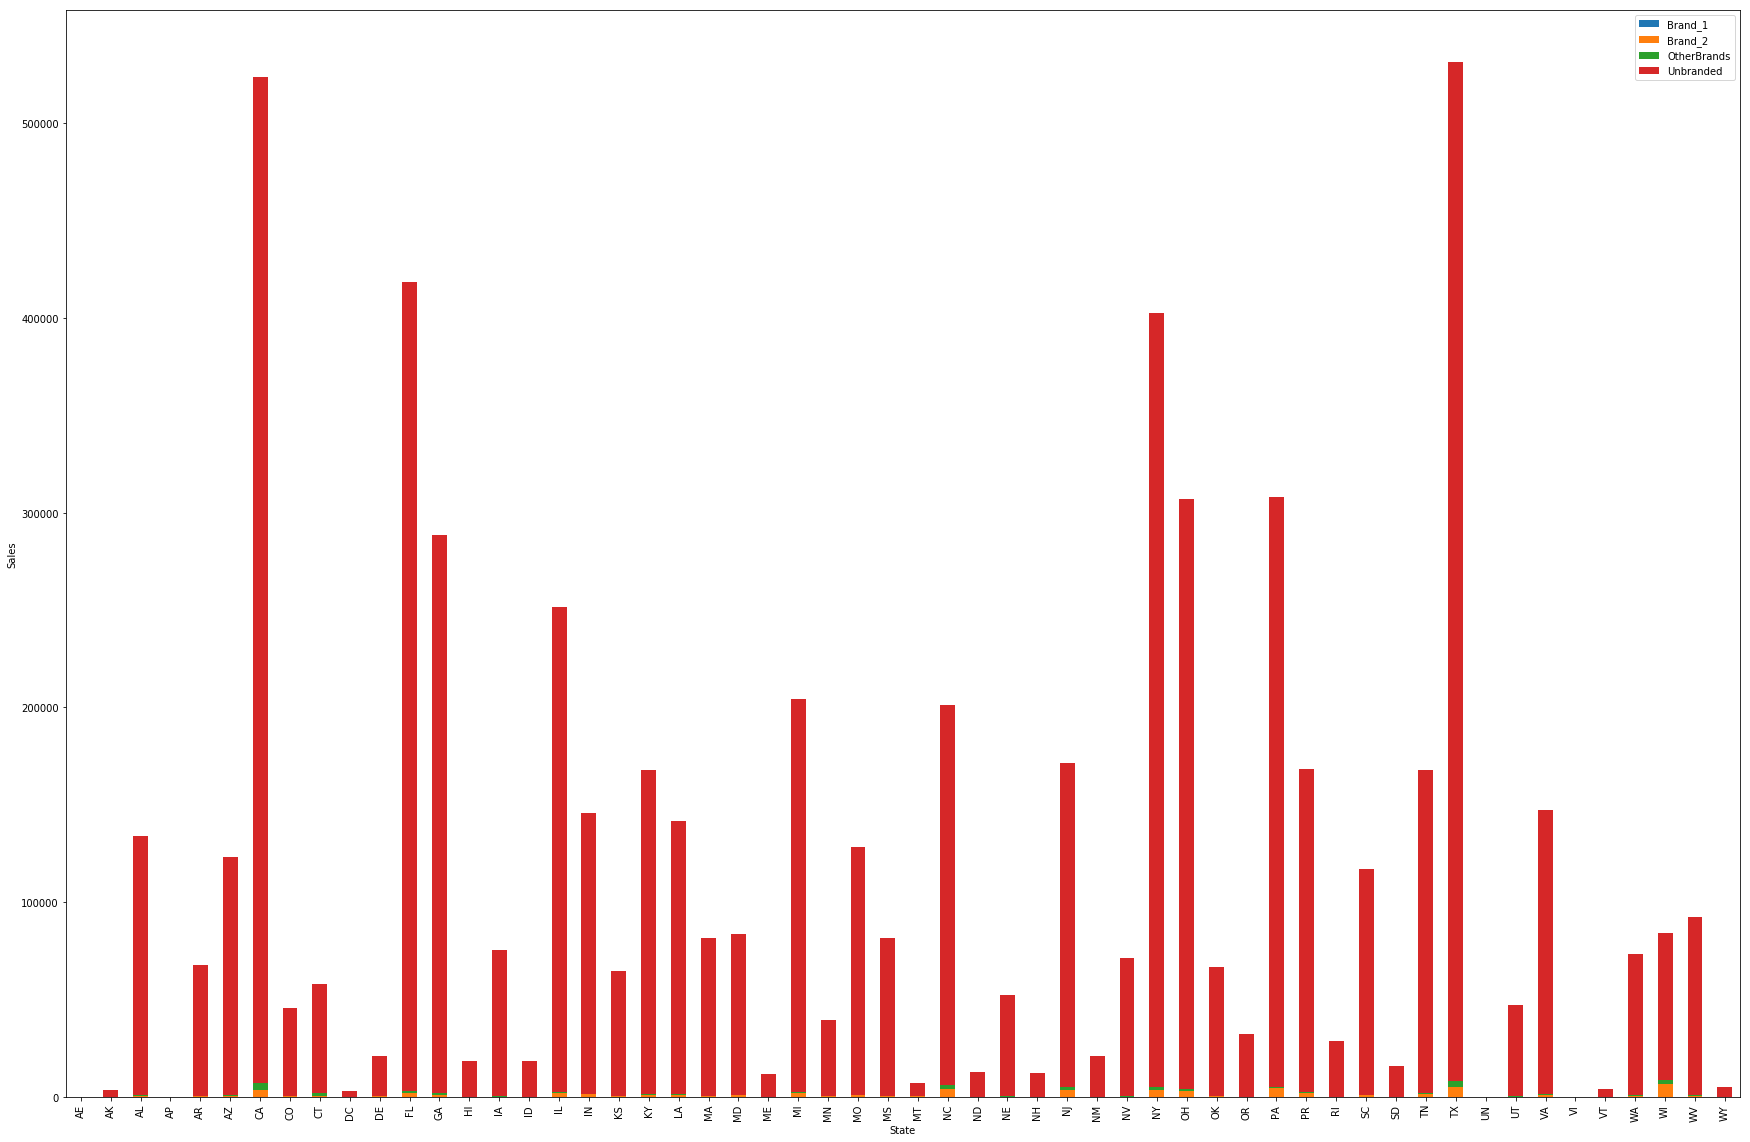

In [541]:
dfState = df.groupby(['State']).agg('sum')[['Brand_1', 'Brand_2', 'OtherBrands', 'Unbranded']]
ax = dfState.plot(kind='bar', figsize=(30,20), stacked=True)
ax.set_ylabel('Sales')

In the plot above, the share of Brand_1, Brand_2, and Other brands is not clearly visible. So let us limit the y axis to (0, 10000) to get a better view:

Text(0,0.5,'Sales')

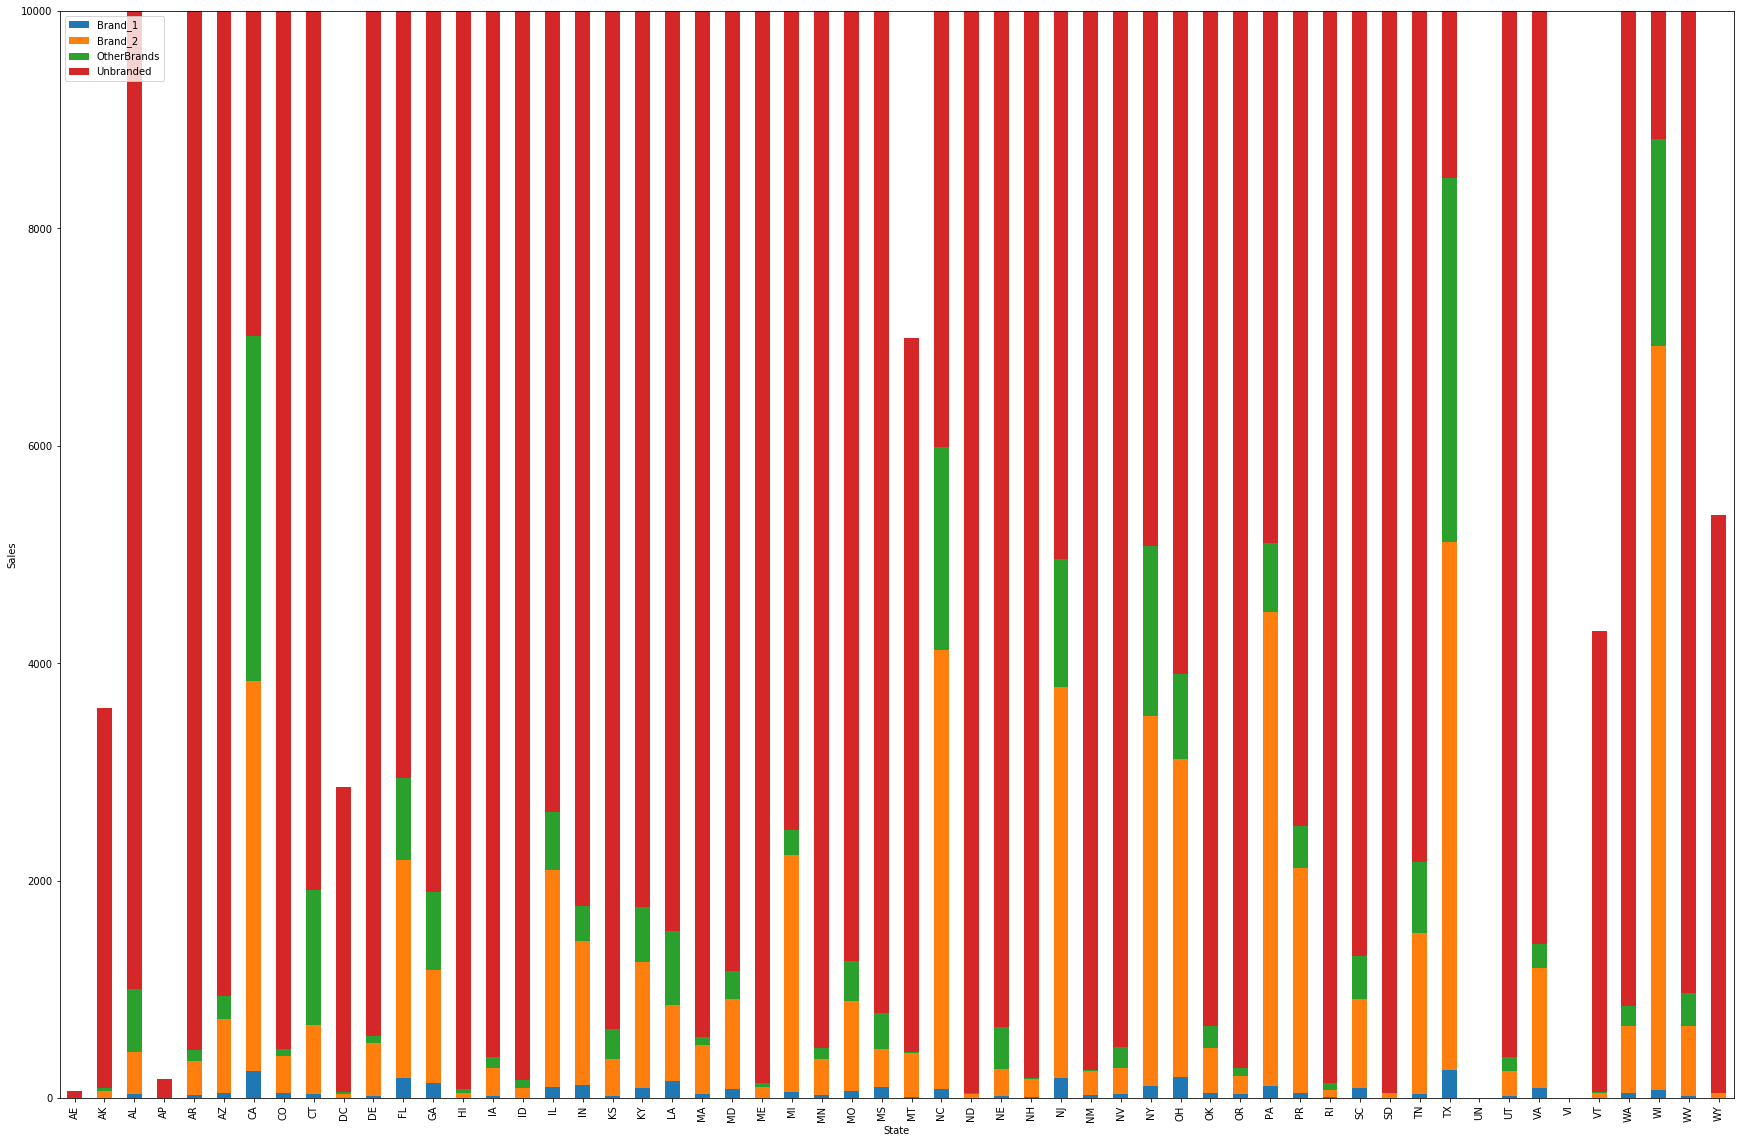

In [542]:
dfState = df.groupby('State').agg('sum')[['Brand_1', 'Brand_2', 'OtherBrands', 'Unbranded']]
ax = dfState.plot(kind='bar', figsize=(30,20), stacked=True)
ax.set_ylim(0, 10000)
ax.set_ylabel('Sales')

Market share of brand 1 in the market for brand 1 and brand 2 alone:

In [543]:
sum(df['Brand_1']) / (sum(df['Brand_1']) + sum(df['Brand_2']))

0.051729624797123126

Market share of brand 2 in the market for brand 1 and brand 2 alone:

In [544]:
sum(df['Brand_2']) / (sum(df['Brand_1']) + sum(df['Brand_2']))

0.9482703752028768

Market share of brand 1 in the whole branded market:

In [545]:
sum(df['Brand_1']) / (sum(df['Brand_1']) + sum(df['Brand_2']) + sum(df['OtherBrands']))

0.036827259648606094

Market share of brand 2 in the whole branded market:

In [546]:
sum(df['Brand_2']) / (sum(df['Brand_1']) + sum(df['Brand_2']) + sum(df['OtherBrands']))

0.6750909070312765

Market share of brand 1 in the whole market (branded + unbranded):

In [547]:
sum(df['Brand_1']) / (sum(df['Brand_1']) + sum(df['Brand_2']) + sum(df['OtherBrands']) + sum(df['Unbranded']))

0.0005117370537293999

Market share of brand 2 in the whole market (branded + unbranded):

In [548]:
sum(df['Brand_2']) / (sum(df['Brand_1']) + sum(df['Brand_2']) + sum(df['OtherBrands']) + sum(df['Unbranded']))

0.009380796590896212

Market share of branded products in the whole market (branded + unbranded):

In [549]:
(sum(df['Brand_1']) + sum(df['Brand_2']) + sum(df['OtherBrands'])) / (sum(df['Brand_1']) + sum(df['Brand_2']) + sum(df['OtherBrands']) + sum(df['Unbranded']))

0.013895605011402717

Market share of unbranded products in the whole market (branded + unbranded):

In [550]:
sum(df['Unbranded']) / (sum(df['Brand_1']) + sum(df['Brand_2']) + sum(df['OtherBrands']) + sum(df['Unbranded']))

0.9861043949885973

# Feature Engineering

In the DataFrame, we now 'Brand_1', 'Brand_2', 'OtherBrands' and 'Unbranded' columns. 'TotalBranded' & 'TotalMarket' columns are now redundant. So we can drop them:

In [551]:
df.drop(['TotalBranded', 'TotalMarket'], axis = 1, inplace=True)

Check the datatypes of features:

In [552]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84080 entries, 0 to 84079
Data columns (total 12 columns):
Title              84080 non-null object
SpecCode           84080 non-null object
State              84080 non-null object
CallAttempts       84080 non-null int64
CallsSuccessful    84080 non-null int64
EmailsSent         84080 non-null int64
EmailsOpened       84080 non-null int64
Faxes              84080 non-null int64
Brand_1            84080 non-null int64
Brand_2            84080 non-null float64
OtherBrands        84080 non-null float64
Unbranded          84080 non-null float64
dtypes: float64(3), int64(6), object(3)
memory usage: 7.7+ MB


Convert non-numeric features into numeric:

In [553]:
labelEncoder = LabelEncoder()
labelEncoder.fit(df['Title'])
df['Title'] = labelEncoder.transform(df['Title'])

labelEncoder.fit(df['SpecCode'])
df['SpecCode'] = labelEncoder.transform(df['SpecCode'])

labelEncoder.fit(df['State'])
df['State'] = labelEncoder.transform(df['State'])

Check the datatypes of features:

In [554]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84080 entries, 0 to 84079
Data columns (total 12 columns):
Title              84080 non-null int64
SpecCode           84080 non-null int64
State              84080 non-null int64
CallAttempts       84080 non-null int64
CallsSuccessful    84080 non-null int64
EmailsSent         84080 non-null int64
EmailsOpened       84080 non-null int64
Faxes              84080 non-null int64
Brand_1            84080 non-null int64
Brand_2            84080 non-null float64
OtherBrands        84080 non-null float64
Unbranded          84080 non-null float64
dtypes: float64(3), int64(9)
memory usage: 7.7 MB


Perform MinMaxScaling on the feature set.

In [555]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Modelling

Cluster the dataset using k-means clustering:

In [556]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Performance Evaluation of the Model

Calculate the Silhouette score of the model.

In [557]:
labels = kmeans.labels_
sil_score = silhouette_score(df_scaled, labels, sample_size=15000)
print('Silhouette score: ', sil_score)

Silhouette score:  0.40069993999721776


# Calculate the channel affinity score

Define softmax function:

In [558]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


Define a function to perform inversing and softmaxing:

In [559]:
def channel_affinity_score(x):
    inverse = 1/x
    return softmax(inverse)

# Find the channel and the channel affinity scores for a customer

Define a function to find the label and channel affinity scores of a data point:

In [560]:
def label_affinity(x):
    cluster_label = {0:'call', 1:'email', 2: 'fax'}
    clus = kmeans.predict(x)
    label = cluster_label[clus[0]]
    
    distance = kmeans.transform(x)
    affinity = channel_affinity_score(distance)
    return label, affinity[0]


Find the recommended marketing channel and the channel affinity scores of a random data point from the dataset: 

In [561]:
datapoint = df_scaled[22832]
dpReshaped = datapoint.reshape(1, -1)
label, affinity = label_affinity(dpReshaped)
print(label, affinity)

email [0.02597481 0.82969686 0.14432833]
